# Autoencoders

In [2]:
import glob
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from torchvision import transforms
import random
from tqdm import tqdm

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Part 1: Image Completion

### Data

The data we are using is [Flickr-Faces-HQ Dataset (FFHQ)](https://github.com/NVlabs/ffhq-dataset). It is an unlabelled dataset used for training GANs and other image generation algorithms. The original dataset has images of size 1024 by 1024 but we have only taken 128 by 128 images. Please download the dataset from this link (https://drive.google.com/drive/folders/1tg-Ur7d4vk1T8Bn0pPpUSQPxlPGBlGfv?usp=sharing)

Since the dataset is large (contains 70,000 image), you'll have to write a DataLoader that loads the data. For this you'll be using the Dataset and DataLoader class that are available in pytorch. For reference, you can get help from this link (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

The input to the network will consist of a image that is modified as shown below. The output label will be the original image.

![title](images/face_dataset.png)

In [3]:
class FaceData(Dataset):
    def __init__(self,files): # add additional parameters needed to load the dataset e.g dataset path
        self.files = files


    def __len__(self):
        return len(self.files)
    def rec(self,img):
      p1 = random.randint(10,100)
      return cv2.rectangle(img,(p1,p1),(p1+20,p1+10),(255,255,255),-1) # image , starting point , ending point , colour , thickness

    def __getitem__(self, idx):
        # your code here
        #Image on which we are going to insert a rectangle
        file = self.files[idx] 
        # The target image (in other words label)
        # The input for the auto encoder
        img = cv2.imread(file)
        img = self.rec(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.transpose(img)
        img = img/255
        # The ground Truth
        target = cv2.imread(file)
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
        target = np.transpose(target)
        target = target/255

        return img,target


In [4]:
import torch.nn.functional as F

class ImageCompletionNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.encoder = nn.Sequential(
          
          nn.Conv2d(3,16,kernel_size= 2,stride= 2),
          nn.BatchNorm2d(16),
          nn.Conv2d(16,32,kernel_size= 2,stride= 2),
          nn.BatchNorm2d(32),
          nn.Conv2d(32,64,kernel_size= 2,stride= 2),
          nn.BatchNorm2d(64),
          nn.Conv2d(64,64,kernel_size= 2),
          nn.BatchNorm2d(64),
          nn.Conv2d(64,64,kernel_size= 2),
          nn.BatchNorm2d(64)

          
      )

      self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2),
            nn.BatchNorm2d(64),
            
            nn.ConvTranspose2d(64, 64, kernel_size=2),
            nn.BatchNorm2d(64),
            
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),

            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            nn.BatchNorm2d(16),

            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
            nn.Sigmoid()
      )


    def forward(self,x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

In [5]:

model = ImageCompletionNet()
print(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
summary(model,(3,128,128))

ImageCompletionNet(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConvTranspose2d(64, 6

Load the data using Custom Dataset class defined above and load your DataLoader. Divide the whole dataset into train, validation and test set.


In [9]:
import random
fd = glob.glob('/content/gdrive/MyDrive/thumbnails128x128/*/*')

l = fd
NewL = l[:int(len(l)*0.2)] 
#NewL = l
random.shuffle(NewL)
train, val, test = NewL[:int(len(NewL)*0.8)],NewL[-int(len(NewL)*0.1):],NewL[-int(len(NewL)*0.1):]
train_set = FaceData(train)
valid_set = FaceData(val)
test_set = FaceData(test)
train_loader = DataLoader(dataset=train_set,batch_size=32,shuffle = True)
valid_loader = DataLoader(dataset=valid_set,batch_size=1,shuffle = True)
test_loader = DataLoader(dataset=test_set,batch_size=1,shuffle = True)

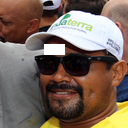

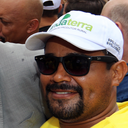

In [11]:
for i in train_loader:

  input , target = i
  cv2_imshow(cv2.cvtColor((255*np.transpose(input[0].detach().cpu().numpy())).astype(np.uint8), cv2.COLOR_BGR2RGB))
  cv2_imshow(cv2.cvtColor((255*np.transpose(target[0].detach().cpu().numpy())).astype(np.uint8), cv2.COLOR_BGR2RGB))
  break   


In [ ]:
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
  
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.03)
#epochs = 20

epochs = 10
outputs = list()
losses = list()
for epoch in tqdm(range(epochs)):

  train_loss = 0
  print(" ")
  for data in tqdm(train_loader):
    input , target = data

    input = input.to(device, dtype=torch.float)
    target = target.to(device, dtype=torch.float)
    optimizer.zero_grad()
    reconstructed = model(input)
    loss = loss_function(reconstructed, target)
 
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  print(" ")
  losses.append(train_loss)
  print("Epoch # {} training loss = {}".format(epoch,train_loss))
  print(" ")
torch.save(model.state_dict(), '/content/gdrive/MyDrive/Deep_Learning_Assignment_3/Part1.pt')

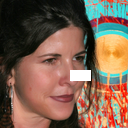

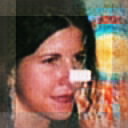

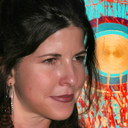

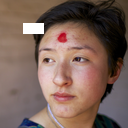

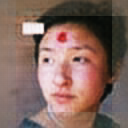

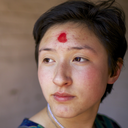

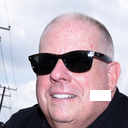

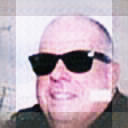

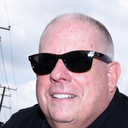

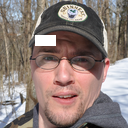

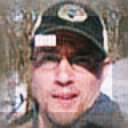

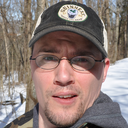

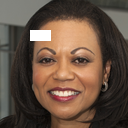

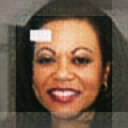

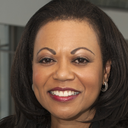

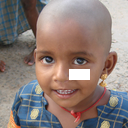

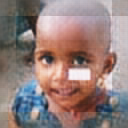

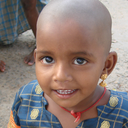

In [10]:
# Your testing pipeline 
c = 0
model = ImageCompletionNet()
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Deep_Learning_Assignment_3/Part1.pt'))
model.eval()
for i in test_loader:
  inp , tar = i
  reconstructed = model(inp)
  cv2_imshow(cv2.cvtColor((255*np.transpose(inp[0].detach().cpu().numpy())).astype(np.uint8), cv2.COLOR_BGR2RGB))
  cv2_imshow(cv2.cvtColor((255*np.transpose(reconstructed[0].detach().cpu().numpy())).astype(np.uint8), cv2.COLOR_BGR2RGB))
  cv2_imshow(cv2.cvtColor((255*np.transpose(tar[0].detach().cpu().numpy())).astype(np.uint8), cv2.COLOR_BGR2RGB))
  if c == 5:
    break
  c += 1


# Part 2: Image Denoising

In [30]:
# Define your Dataset Class here as done in Part 1
class ImageDenoising(Dataset):
    def __init__(self,files): # add additional parameters needed to load the dataset e.g dataset path
        self.files = files

    def __len__(self):
        return len(self.files) # this would return us the number of images we have

    def add_noise(self,img):
      row , col = img.shape[0] , img.shape[1]
      number_of_pixels = random.randint(1000, 3000)
      for i in range(number_of_pixels):
          y_coord=random.randint(0, row - 1)
          x_coord=random.randint(0, col - 1)
          img[y_coord][x_coord] = 255

      number_of_pixels = random.randint(1000 , 3000)
      for i in range(number_of_pixels):
          y_coord=random.randint(0, row - 1)
          x_coord=random.randint(0, col - 1)
          img[y_coord][x_coord] = 0
      return img

    def __getitem__(self, idx):
        #Image on which we are going to insert a rectangle
        file = self.files[idx] 
        # The target image (in other words label)
        # The input for the auto encoder
        img = cv2.imread(file)
        img = cv2.resize(img,dsize= (256,256))
        img = self.add_noise(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.transpose(img)
        img = img/255
        # The ground Truth
        target = cv2.imread(file)
        target = cv2.resize(target,dsize= (256,256))
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
        target = np.transpose(target)
        target = target/255

        return img, target



In [31]:
#Creating DataSet
#spliting the data 
import random
fd = glob.glob('/content/gdrive/MyDrive/persondataset/person_dataset/images/*')
l = fd
NewL = l[:int(len(l)*0.2)] 
random.shuffle(NewL)
train, val, test = NewL[:int(len(NewL)*0.8)],NewL[-int(len(NewL)*0.1):],NewL[-int(len(NewL)*0.1):]
train_set = ImageDenoising(train)
valid_set = ImageDenoising(val)
test_set = ImageDenoising(test)
train_loader2 = DataLoader(dataset=train_set,batch_size=64,shuffle = True)
valid_loader2 = DataLoader(dataset=valid_set,batch_size=1,shuffle = True)
test_loader2 = DataLoader(dataset=test_set,batch_size=1,shuffle = True)

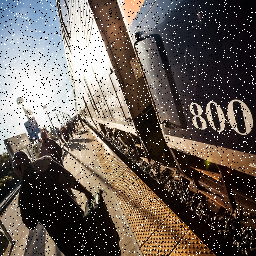

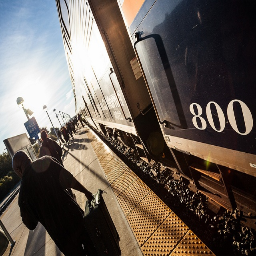

In [35]:
for i in test_loader2:
  input , target = i
  cv2_imshow(cv2.cvtColor((255*np.transpose(input[0].detach().cpu().numpy())).astype(np.uint8), cv2.COLOR_BGR2RGB))
  cv2_imshow(cv2.cvtColor((255*np.transpose(target[0].detach().cpu().numpy())).astype(np.uint8), cv2.COLOR_BGR2RGB))
  break

In [40]:
# Define your model here
import torch.nn.functional as F

class Denoising(nn.Module):
    def __init__(self):
      super().__init__()
      self.encoder = nn.Sequential(
          
          nn.Conv2d(3,16,kernel_size= 2 , stride = 2),
          nn.BatchNorm2d(16),

          nn.Conv2d(16,32,kernel_size= 4),
          nn.BatchNorm2d(32),
          nn.Conv2d(32,64,kernel_size= 4),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.Conv2d(64,64,kernel_size= 2,stride = 2),
          
          nn.BatchNorm2d(64),


          
      )

      self.decoder = nn.Sequential(

            
            nn.ConvTranspose2d(64, 64, kernel_size=2,stride = 2),
              nn.BatchNorm2d(64),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4),
            nn.ReLU(),
              nn.BatchNorm2d(32),

            nn.ConvTranspose2d(32, 16, kernel_size=4),
              nn.BatchNorm2d(16),

            nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),
              nn.BatchNorm2d(3),
            nn.Sigmoid()
      )


    def forward(self,x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

In [41]:
# Print your model here using summary from torchsummary
model = Denoising()
print(model)
model = model.to(device)
summary(model,(3,128,128))

Denoising(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [ ]:
# Your training pipeline
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
  
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.03)
#epochs = 20

epochs = 10
outputs = list()
losses = list()
for epoch in tqdm(range(epochs)):

  train_loss = 0
  print(" ")
  for data in tqdm(train_loader2):
    input , target = data
    input = input.to(device, dtype=torch.float)
    target = target.to(device, dtype=torch.float)
    optimizer.zero_grad()
    reconstructed = model(input)
    loss = loss_function(reconstructed, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  print(" ")
  losses.append(train_loss)
  print("Epoch # {} training loss = {}".format(epoch,train_loss))
  
torch.save(model.state_dict(), '/content/gdrive/MyDrive/Deep_Learning_Assignment_3/Part2.pt')

Load your model using the weights you obtained from training and evaluate them on the test dataset. Your results will be evaluated on the basis of the image denoising results. You will need to display your noise images along with the results in the form of 5x2 matrix (You can pick any random 5 images for display. Your image selector should be written as a method that generates random samples for testing)

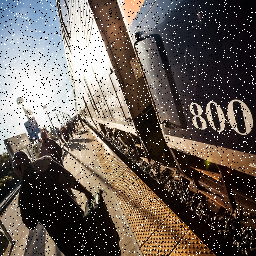

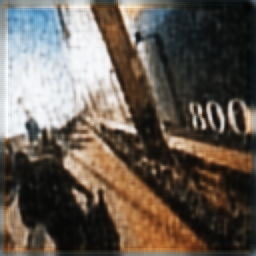

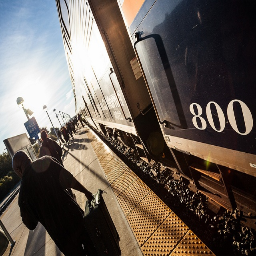

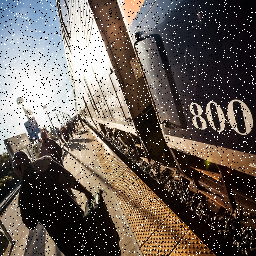

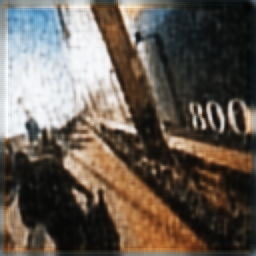

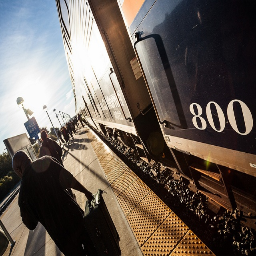

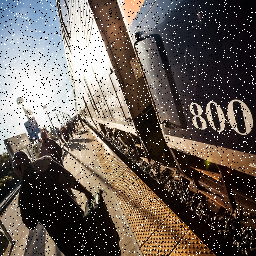

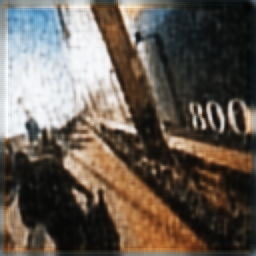

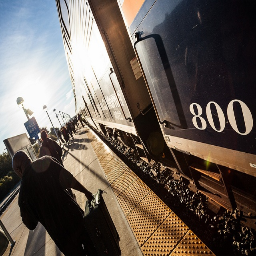

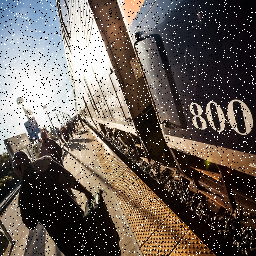

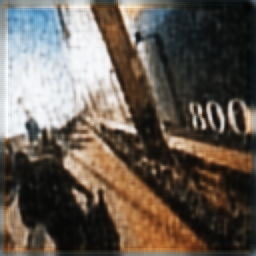

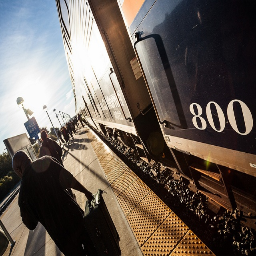

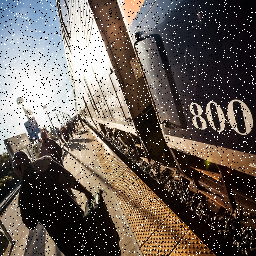

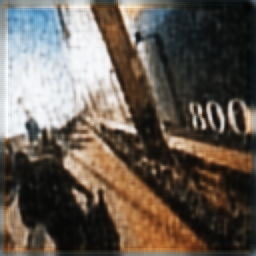

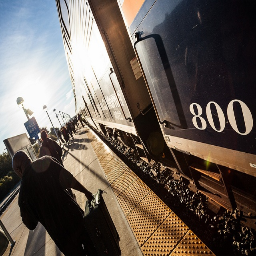

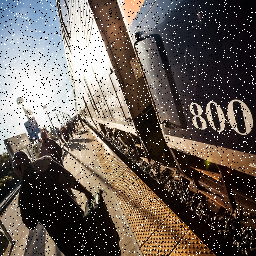

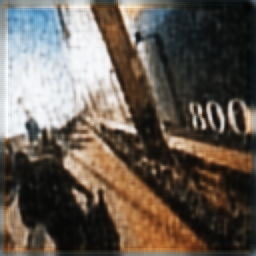

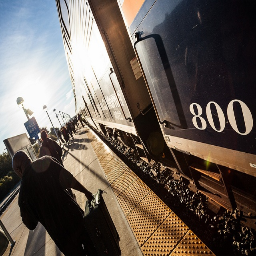

In [42]:
# Your testing pipeline 
c = 0
model = Denoising()
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Part2.pt'))
model = model.to(device)
model.eval()
for i in test_loader2:
  inp , tar = i
  inp = input.to(device, dtype=torch.float)
  tar = target.to(device, dtype=torch.float)
  reconstructed = model(inp)
  cv2_imshow(cv2.cvtColor((255*np.transpose(inp[0].detach().cpu().numpy())).astype(np.uint8), cv2.COLOR_BGR2RGB))
  cv2_imshow(cv2.cvtColor((255*np.transpose(reconstructed[0].detach().cpu().numpy())).astype(np.uint8), cv2.COLOR_BGR2RGB))
  cv2_imshow(cv2.cvtColor((255*np.transpose(tar[0].detach().cpu().numpy())).astype(np.uint8), cv2.COLOR_BGR2RGB))
  if c == 5:
    break
  c += 1
